In [2]:
# evaluate this cell to have jupyter use all the available horizontal screen space
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lattice completion for concatenated GKP codes

The present notebook implements a procedure to find minimal sets of stabilizers of concatenated Gottesman-Kitaev-Preskill codes detailed in [arXiv:2109.14645](https://arxiv.org/abs/2109.14645).

As an example, a (square) patch of rotated surface code concatenated with a square GKP base code is examined.

#### imports and general definitions

In [3]:
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt

# the two following imports are useful if the lattice membership test is to be carried out with integer arithmetics
# the package abelian can be installed via pip3 install abelian
# see https://buildmedia.readthedocs.org/media/pdf/abelian/latest/abelian.pdf for documentation

from abelian import * # for Hermite normal form  and linear algebra over integers
from sympy import Matrix, Integer


In [4]:
def Jsym(n): # symplectic form for n modes
    return np.block([[np.zeros((n,n)), np.eye(n)],[-np.eye(n),np.zeros((n,n))]])

In [5]:
np.set_printoptions(precision=3, linewidth=1000) # for concise output without line wrapping

# Square patch of rotated surface code 

## Code parameters

In [6]:
L = 3 # surface code distance
N = L**2 # number of physical modes
J = Jsym(N) # symplectic form

#### A useful code class

In the following, we distinguish between lattice units and physical units. 

Lattice units are useful to make quantities like the symplectic Gram matrix integer. See article for details on conventions.

In [7]:
class surfaceCode(object):
    '''
    a container for surface code-related functions
    
    In particular, the code produces parity and lattice-generator matrices for a square patch of rotated surface code of size LxL (see article for details)
    
    HX and HZ are the X and Z parity-check matrices, which naturally correspond to lattice generators.
    
    If signed == True, then some of the qubit-level stabilizers are defined using adjoint of logical Paulis,
    which has been shown to minimize error spreading between qubit-type stabilizers.
    '''
    
    def __init__(self, l, signed=True): # initialize code of distance l
        self.l = l
        self.qposx = np.linspace(0, l-1, l) 
        self.qposy = np.linspace(0, l-1, l) 
        self.qubits = [(x,y) for x in self.qposx for y in self.qposy]
        self.signed=signed
        self.set_HX()
        self.set_HZ()
        #self.set_lattice_gens()
        #self.set_logicals()
    
    def set_HX(self):
        HX = []
        for y in range(self.l-1): # first take care of "bulk" stabilizers
            for x in range(self.l-1):
                if (self.l*x+y)%2 == 0:    # <=> pivot elem of checkerboard (x%2==0) and (y%2 ==0) for odd l.  Qubit index I(x,y)=ly+x
                    s = [0 for j in range(self.l**2)]
                    s[self.l*y + x] = (-1)**(self.signed)
                    s[self.l*y + x +1] = 1
                    s[self.l*(y+1) + x] = 1
                    s[self.l*(y+1) + x + 1] = (-1)**(self.signed)
                    HX.append(s)
                    
        for x in range(1,self.l-1,2): # stabilizers on top edge
            s = [0 for j in range(self.l**2)]
            s[x] = 1
            s[x + 1] = (-1)**(self.signed)
            HX.append(s)
            
        for x in range(0,self.l-2,2): # stabilizers on bottom edge
            s = [0 for j in range(self.l**2)]
            s[self.l*(self.l-1)+x] = (-1)**(self.signed)
            s[self.l*(self.l-1)+x + 1] = 1
            HX.append(s)
        
        self.HX = np.array(HX)
    
    def set_HZ(self):
        HZ = []
        for y in range(self.l-1): # first take care of "bulk" stabilizers
            for x in range(self.l-1):
                if (self.l*x+y)%2 == 1: #<=> (x%2==1)^(y%2==1)
                    s = [0 for j in range(self.l**2)]
                    s[self.l*y + x] = 1
                    s[self.l*y + x +1] = 1
                    s[self.l*(y+1) + x] = 1
                    s[self.l*(y+1) + x + 1] = 1
                    HZ.append(s)

        for y in range(0,self.l-2,2): # stabilizers on left edge
            s = [0 for j in range(self.l**2)]
            s[self.l*y] = 1
            s[self.l*(y+1)] = 1
            HZ.append(s)

        for y in range(1,self.l-1,2): # stabilizers on right edge
            s = [0 for j in range(self.l**2)]
            s[self.l*y + self.l-1] = 1
            s[self.l*(y+1) + self.l-1] = 1
            HZ.append(s)

        self.HZ = np.array(HZ)
        
        
    def get_HX(self):
        return self.HX

    def get_HZ(self):
        return self.HZ

## Stabilizer generators

### GKP generators

In [8]:
MGKPt = 2*np.sqrt(np.pi)*np.eye(2*N) # lattice generator of mode-wise GKP code, in physical units
MGKP = (1./np.sqrt(2*np.pi))*MGKPt # generator matrix in lattice unit --> the corresponding A matrix below is integer
AGKP = MGKP@J@np.transpose(MGKP)

### Surface code generators

In [9]:
C = surfaceCode(L, signed=True) # instantiate auxiliary SC class
HX = C.get_HX() # X type parity check matrix
HZ = C.get_HZ() # Z type parity check matrix
MSurft = np.sqrt(np.pi)*np.block([[HX,np.zeros(np.shape(HX))],[np.zeros(np.shape(HX)),HZ]]) # corresponding generator matrix
MSurf = (1./np.sqrt(2*np.pi)) * MSurft # rescaled generator matrix

In [38]:
print(f"This is the zero matrix for a CSS code\n {HX@(HZ.T)%2}\n") # check it's CSS
A=MSurf@J@MSurf.T
print(f"The symplectic Gram matrix A should always be integer (zero if using the signed surface code) \n A =  {A}\n")#check that A matrix is integer (or zero if signed == True in the surface code)
print(f"the determintant of A is also zero if using the signed surface code \n det(A) = {la.det(A)}")

This is the zero matrix for a CSS code
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]

The symplectic Gram matrix A should always be integer (zero if using the signed surface code) 
 A =  [[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.237e-17 -2.237e-17  2.237e-17  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  2.237e-17  2.237e-17  0.000e+00 -2.237e-17]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.237e-17  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  2.237e-17  0.000e+00  0.000e+00]
 [ 2.237e-17 -2.237e-17  2.237e-17  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 2.237e-17 -2.237e-17  0.000e+00 -2.237e-17  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-2.237e-17  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  2.237e-17  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]

the determintant of A is also zero if using the signed surface code 
 det(A) = 6.27

### (over-)Complete set of generators

In [22]:
Mtot = np.vstack([MGKP,MSurf]) # an over-complete set of generators for the lattice of the concatenated code

In [26]:
print(f"scaled version of the over-complete generator, integer for the square GKP as base code \n{(np.sqrt(2)*Mtot)}\n") # sqrt(2) makes the matrix integer for the square code, which is useful if one wants to use the abelian module

scaled version of the over-complete generator, integer for the square GKP as base code 
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0

# Basis reduction algorithms

## Lattice reduction through Hermite decomposition

To appreciate the importance of the reduction algorithm in the article, we show first how things can go wrong using naive lattice reduction, e.g. through computing Hermite normal form.

In [27]:
Lmat = np.sqrt(2)*Mtot # make the matrix integer to work with lattice functions

Lmat = Matrix(Lmat.astype(int)) # the abelian module works with sympy Matrix objects
#print(Lmat)

In [28]:
U,H = hermite_normal_form(Lmat.T) # U is unimodular, the columns of H correspond to the new nullifiers


# let's convert back to numpy float arrays
U = np.array(U).astype(np.float64)
H = np.array(H).astype(np.float64)

newMmat = (1/np.sqrt(2))*H.T # the new generator matrix, rows are the new independent generators

In [30]:
print(f"the new generator seems to still have 26 rows, as seen from the shape \n{newMmat.shape}")
print(f"but if we remove all-zero rows we correctly get the shape \n {(newMmat[~np.all(newMmat == 0, axis=1)]).shape}")

the new generator seems to still have 26 rows, as seen from the shape 
(26, 18)
but if we remove all-zero rows we correctly get the shape 
 (18, 18)


In [57]:
#print(U,"\n")
print('If the Hermite decomposition worked, this should be 1: ',la.det(U),"\n") # check that U is unimodular
#print(H, "\n")
print('If the Hermite decomposition worked, this should be the zero matrix: \n\n', np.array(Lmat.T).astype(np.float64)@U-H,"\n") # check the Hermite decomposition


#print(newMmat[:2*N],"\n")
gen = newMmat[~np.all(newMmat == 0, axis=1)] # retain only non zero rows
#print(gen) #only pick non-zero rows

print("The determinant of the new generator should give the dimension of the stabilized subspace:",la.det(gen))

If the Hermite decomposition worked, this should be 1:  1.0 

If the Hermite decomposition worked, this should be the zero matrix: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [41]:
A=gen@J@gen.T # the symplectic gram matrix
A_Inv=la.inv(A) # and its inverse

### Properties of the new stabilizers

Inspecting the new generator, we see that the lattice reduction respects the CSS structure of the code.  

What can we say about the new stabilizer operators? 

The first question is about their weight, that is on how many modes do they act non trivially? 

This corresponds to the number of non zero entries in each row of the new generator matrix newMmat. This is also equal to the number of controlled operations required for each stabilizer. The sum of the weights across all stabilizers gives the total number of controlled gates required in a single round of error correction.

In [42]:
#gen = newMmat[:2*N]
weights = [np.count_nonzero(r) for r in gen]
oldWeights = [np.count_nonzero(r) for r in Mtot]
sortedWeights = sorted(weights)
sortedOldWeights = sorted(oldWeights)

In [44]:
print(sortedWeights)
print(sortedOldWeights)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 4, 4, 4, 6]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 4]


We see that there are fewer stabilizers but they generally have higher weight. 

This is shown in the following plot as well.

number of old stabilizers:  26 ; number of controlled ops:  42
number of new stabilizers:  18 ; number of controlled ops:  38


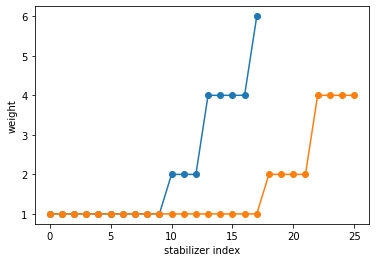

In [45]:
print("number of old stabilizers: ",np.size(oldWeights),"; number of controlled ops: ", np.sum(oldWeights))
print("number of new stabilizers: ",np.size(weights),"; number of controlled ops: ", np.sum(weights))

plt.plot([j for j in range(len(sortedWeights))],sortedWeights,"o-")
plt.plot([j for j in range(len(sortedOldWeights))],sortedOldWeights,"o-")

plt.xlabel('stabilizer index')
plt.ylabel('weight')

plt.show()

## Adding GKP generators one at a time

The code below implements the procedure in the article. The advantage is that this preserves the weight of the qubit-level code.

There are two options for the membership test: either the membership to the lattice is computed up to numerical precision using floating point arithmetics or the module abelian is used to search a solution of Mx = v with x integer and x a candidate lattice points.

The latter option requires having installed abelian and Simpy. Furthermore, the units have to be chosen such that the generator matrix is integer.

Which membership test is used is governed by the variable intAr below.

**WARNING** in this example code the test based on integer arithmetics is only implemented for the square GKP code as base code.

In [49]:
intAr = True

In [50]:
def is_in_lattice_intAr(v,M):
    '''
    returns True if v is in the integer span of columns of M (using integer arithmetics from the abelian package)
    
    If Mx == v then x is also returned, otherwise the second returned value is None
    '''
    
    sol = solve(Matrix(M),Matrix(v.astype(int)) )
    
    if (sol != None): 
        return True, np.array(sol.T).astype(np.float64)[0]
    return False, sol

def is_in_lattice(v,M):
    '''
    returns True if v is in the integer span of columns of M (up to numerical precision)
    
    If Mx == v then x is also returned, otherwise the second returned value is None
    '''
    
    sol = la.lstsq(M, v, rcond = None)[0] # finds best approximation to v within the subspace spanned by columns of M using least squares
    ans = False

    if np.allclose(M@sol, v) and np.allclose(sol, np.round(sol)): # if the solution x to Mx = v is integer (within numerical precision)
        ans = True # then v is in the lattice
    return ans, sol

def CC_lattice_completion(Mqubit,Mbase, verbose = False, check = False):
    '''
    Completes the lattice generator of a concatenated code given qubit code and mode-wise GKP lattice generator.
    Starting from the lattice generated by qubit code stabilizers, 
    checks if each GKP stabilizer is contained in the lattice and if not, adds it to the lattice generators. 
    
    input:
        Mqubit: (N-k)x2N matrix, lattice generator for qubit code with k logical qubits over N phyisical qubits
        Mbase: 2Nx2N matrix, the lattice generator matrix for encoding a GKP qubit on each mode
        verbose: bool, if True prints additional messages, default False
        check: bool, if True there is an additional check on linear dependency of single-mode stabilizers
    output:
        Mtot: 2Nx2N matrix, rows are a (possibly overcomplete) set of lattice generators for the GKP surface code
        
        
    CONVENTIONS: 
        each row of the input qubit generator corresponds to Pauli strings: 
            entries are in {0,1,-1}, first N entries correspond to X, last N entries to Z. 
        Entries are exponent of the operators. 
        Example: 
            for 3 qubits with first stabilizer XIZ^\dagger we have M_1 = (1,0,0,0,0,-1).
    '''
    
    global intAr
    
    if intAr:
        Ltot = np.sqrt(2)*Mqubit # the total generator is grown from the qubit code, rows correspond to stabilizers
        LGKPleft = np.sqrt(2)*Mbase # generator of base code for all modes
    else:
        Ltot = Mqubit # the total generator is grown from the qubit code, rows correspond to stabilizers
        LGKPleft = Mbase # generator of base code for all modes
    

    #print('shape Ltot ',np.shape(Ltot))
    #print('shape LGKPleft ', np.shape(LGKPleft))

    while len(LGKPleft)>0: # if there are single-mode GKP generators left
        if verbose:
            print("{} GKP generators left".format(LGKPleft.shape[0]))
        
        if intAr:
            member, sol = is_in_lattice_intAr(LGKPleft[0],Ltot.T) # check if the vector is an integer lin comb of the generators already found
        else:
            member, sol = is_in_lattice(LGKPleft[0],Ltot.T) # check if the vector is an integer lin comb of the generators already found
        if member: # if the first lies on the lattice
            if verbose:
                print("found a GKP generator already in the lattice")
            if check:
                diff = sol@Ltot - LGKPleft[0]
                mismatch = la.norm(diff)
                if verbose:
                    print("solution verified, norm mismatch: ", mismatch)
                    print("the solution to the linear system is ", sol) # check that the solution is indeed integer
                if np.abs(mismatch) > 10**(-8):
                    print('linear dependency could not be verified, the norm mismatch is: {}; exiting'.format(mismatch))
                    return -1
        else:
            Ltot = np.vstack((Ltot,LGKPleft[0])) # otherwise add it to the generators
            
        LGKPleft = np.delete(LGKPleft,0,0) # remove the current GKP stabilizer from the list of those to check
        
    if verbose:
        print("\n reduction completed successfully, returning {} independent generators".format(Ltot.shape[1]))
    
    if intAr:
        return (1/np.sqrt(2))*Ltot
    
    return Ltot 
    

In [48]:
newMmat = CC_lattice_completion(MSurf,MGKP, check = True, verbose = True)

18 GKP generators left
17 GKP generators left
16 GKP generators left
found a GKP generator already in the lattice
solution verified, norm mismatch:  1.5565144948272768e-15
the solution to the linear system is  [ 1.227e-16  2.906e-16 -2.000e+00 -8.512e-16 -2.579e-17  6.779e-17  2.981e-17  9.148e-31  3.226e-16  1.000e+00]
15 GKP generators left
14 GKP generators left
found a GKP generator already in the lattice
solution verified, norm mismatch:  1.3929636468545002e-15
the solution to the linear system is  [-2.000e+00 -6.672e-16 -2.521e-16  3.195e-16 -8.670e-17 -5.069e-17 -6.766e-17  2.089e-16 -1.000e+00  1.000e+00  1.000e+00]
13 GKP generators left
12 GKP generators left
11 GKP generators left
found a GKP generator already in the lattice
solution verified, norm mismatch:  1.461088621293603e-15
the solution to the linear system is  [ 1.049e-16 -8.567e-16  1.074e-16  2.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.616e-17  3.111e-16 -3.698e-16 -4.486e-16 -1.439e-17  1.000e+00]
10 GKP generat

In [54]:
print(f"the new generator matrix (rows correspond to new stabilizers)\n {newMmat}\n")
print("shape before removing all-zero rows ",np.shape(newMmat))
gen = newMmat[~np.all(newMmat == 0, axis=1)] # retain only nonzero rows, should be all of them
print("shape AFTER removing all-zero rows (just in case) ",np.shape(newMmat))
weights = [np.count_nonzero(r) for r in gen]
oldWeights = [np.count_nonzero(r) for r in Mtot]
sortedWeights = sorted(weights)
sortedOldWeights = sorted(oldWeights)
print("check encoded dimension det(A) = ", la.det(gen))

the new generator matrix (rows correspond to new stabilizers)
 [[-0.707  0.707  0.     0.707 -0.707  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.707  0.707  0.     0.707 -0.707  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.707 -0.707  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.707  0.707  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.707  0.707  0.     0.707  0.707  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.707  0.707  0.     0.707  0.707  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.707  0.     0.     0.707  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0. 

number of old stabilizers:  26  number of controlled ops:  42
number of new stabilizers:  18  number of controlled ops:  34


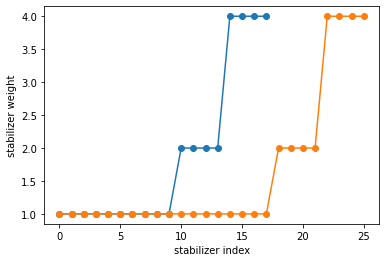

In [55]:
print("number of old stabilizers: ",np.size(oldWeights)," number of controlled ops: ", np.sum(oldWeights))
print("number of new stabilizers: ",np.size(weights)," number of controlled ops: ", np.sum(weights))

plt.plot([j for j in range(len(sortedWeights))],sortedWeights,"o-")
plt.plot([j for j in range(len(sortedOldWeights))],sortedOldWeights,"o-")
plt.xlabel('stabilizer index')
plt.ylabel('stabilizer weight')
plt.show()